## Detection of supra-glacial lakes using natural-color imagery and NDWI<sub>ice</sub>

During the Arctic summer, surface melting on the Greenland Ice Sheet can produce meltwater near the ice sheet's margins. 
The seasonal meltwater pools in supraglacial lakes in topographic lows on the ice surface and forms a dendritic pattern of meandering streams and rivers that often connects the lakes hydrologically (e.g., [Studinger et al., 2022](https://doi.org/10.5194/tc-16-3649-2022)).

To detect water on the ice sheet, the normalized difference water index modified for ice NDWI<sub>ice</sub> that increases the spectral contrast between liquid water and snow and ice surfaces can be used (e.g., [Yang and Smith (2013)](https://doi.org/10.1109/LGRS.2012.2224316)). [Studinger et al., 2022](https://doi.org/10.5194/tc-16-3649-2022)) used NDWI<sub>ice</sub> for high-resolution surface classification of individual laser footprints from NASA's Airborne Topographic Mapper natural-color imagery. 
The NDWI<sub>ice</sub> of natural-color, three-channel (red, green, blue) images is defined as:


$$
NDWI_{ice} = \frac{blue - red} {blue + red}
$$

## Python™ code for calculating NDWI<sub>ice</sub>
First, load the required modules and build the image file name.

In [1]:
# load required modules and build file name for image
import os
import numpy as np
from   PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from   matplotlib.colors import ListedColormap

# set input directory with image file
f_dir_imagery = r".." + os.sep + "data" + os.sep + "imagery"
# set input file name for Jupyter notebook
f_name_rgb = f_dir_imagery + os.sep + "IOCAM0_2019_GR_NASA_20190506-131614.4217.jpg"

Import natural-color, three-channel (red, green, blue) image frame using the Pillow fork of the [Python Imaging Library](https://pillow.readthedocs.io/en/stable/). The lakes appear as sapphire-blue features to the eye and in natural color imagery. The image is appoximately 480 m wide and 310 m high. 

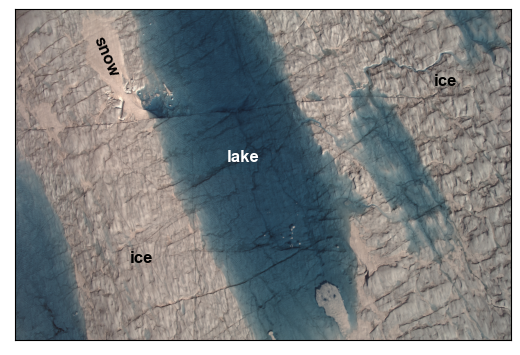

In [2]:
# import natural-color image and plot it
rgb_image = Image.open(f_name_rgb)

fig, (ax1) = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
handle_ax1 = ax1.imshow(rgb_image)
handle_txt = ax1.text(1250,2500, "ice", fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle_txt = ax1.text(4250,750,  "ice", fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle_txt = ax1.text(2250,1500, "lake",fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle_txt = ax1.text(900,650,   "snow",fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

Calculate NDWI<sub>ice</sub> from natural-color image and plot NDWI<sub>ice</sub> 

In [3]:
# calculate NDWI_ice from natural-color image
def calc_ndwi(rgb_image):
    """
    SUMMARY:       Calculation of NDWI_ice from a three-channel (RGB) natural-color image 
    
    INPUT:        
    rgb_image      three-channel (RGB) natural-color image as type Image    
                   
    OUTPUT:        vector with ECEF coordinates of the camera's focal plane

    SYNTAX:        ndwi = calc_ndwi(rgb_image)
    """

    # first put RGB image into an uint8 array    
    rgb_array = np.array(rgb_image)
    # convert uint8 to float64 for NDWI_ice calculation
    rgb_array = rgb_array.astype(np.float64)
    # red, green, and blue channels are first, second and third dimension of rgb_array
    # NDWI_ice = (blue - red)/(blue + red)
    red  = rgb_array[:,:,0]
    blue = rgb_array[:,:,2]

    ndwi = (blue - red)/(blue + red)
    
    return ndwi

# calculate NDWI_ice
ndwi = calc_ndwi(rgb_image)

Make color-coded plot of NDWI<sub>ice</sub> over natural-color image with an alpha channel (transparency) separating snow & ice from water:

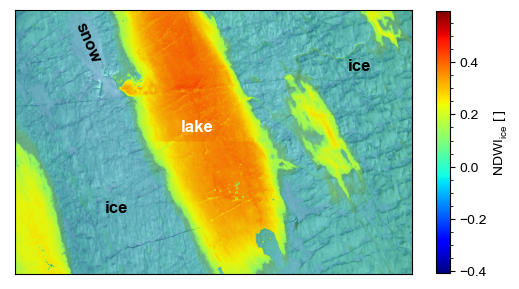

In [4]:
# create alpha channel for different transparencies
ndwi_alpha = ndwi * 0.0
ndwi_threshold = 0.1139393939393944 # using Otsu threshold estimated below
indx1 = (ndwi >= ndwi_threshold) # output is 2-D boolean array
ndwi_alpha[indx1] = 0.95         #  
indx2 = (ndwi < ndwi_threshold)  # output is 2-D boolean array
ndwi_alpha[indx2] = 0.40         # 

fig2, (ax2) = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
handle_ax2  = ax2.imshow(rgb_image)
handle_ndwi = ax2.imshow(ndwi, interpolation='bilinear',cmap = plt.cm.jet,alpha = ndwi_alpha)

handle_txt = ax2.text(1250,2500, "ice", fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle_txt = ax2.text(4250,750,  "ice", fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle_txt = ax2.text(2250,1500, "lake",fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle_txt = ax2.text(900,650,   "snow",fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

cbar = fig2.colorbar(handle_ndwi, ax=ax2,location='right',label=r'$\regularNDWI_{ice}$ [ ]', shrink = 0.71) 
cbar.minorticks_on()

## Surface classification distinguishing snow & ice from water using Otsu thresholds
A common approach for classifying regions in gray-scale images is [Otsu's method](https://ieeexplore.ieee.org/document/4310076) that applys automatic image thresholding. The Python™ function below is from https://en.wikipedia.org/wiki/Otsu's_method and has been modified for using NDWI<sub>ice</sub> arrays that are stored as type ```float64``` instead of the commonly use ```uint8``` for images.

In [5]:
# apply a surface classification method that distinguishes between ice/snow and water using
# NDWI_ice and Otsu's method for image classification. The function below is from
# https://en.wikipedia.org/wiki/Otsu's_method and has been modified for using 
# NDWI_ice values that are stored as type float64 instead of the commonly used uint8 for images.

# turn warnings off. it is not clear why the first run throws a warning in Jupyter, but not in Python
# and why subsequent execusions of this cell don't throw a warning
import warnings
warnings.filterwarnings('ignore')

def otsu_intraclass_variance(image, threshold):
    """
    Otsu’s intra-class variance. If all pixels are above or below the threshold,
    this will throw a warning that can safely be ignored.
    """
    return np.nansum([
        np.mean(cls) * np.var(image, where=cls)
        # weight intra-class variance
        for cls in [image >= threshold, image < threshold]
    ])
    # NaNs only arise if the class is empty, in which case the contribution should be zero, which `nansum` accomplishes.

otsu_threshold = min(np.arange(np.min(ndwi), np.max(ndwi), 0.01),key = lambda th:otsu_intraclass_variance(ndwi, th))

Use the Otsu threshold to create a 2-D surface classification array with 0 for snow & ice and 1 for water. 

In [6]:
# create a 2-D surface classification array with 0 for snow & ice and 1 for water
indx = (ndwi >= otsu_threshold) # output is 2-D boolean array
ndwi_srf_class = ndwi * 0.0     # array with same dimensions as NDWI_ice and all 0
ndwi_srf_class [indx] = 1.0     # sets ndwi_srf_class to 1.0 above the Otsu threshold

Plot transparent surface classification (snow & ice vs. water) based on Otsu's threhold for NDWI<sub>ice</sub> over natural-color image.

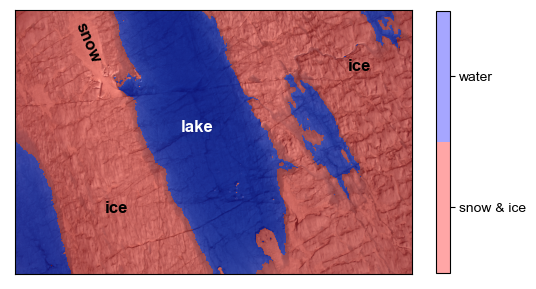

In [7]:
cmap_srf = (mpl.colors.ListedColormap(['red', 'blue']))
bounds = [0, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap_srf.N)

fig4, (ax4) = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
handle_ax4  = ax4.imshow(rgb_image)
handle_reg  = ax4.imshow(ndwi_srf_class, interpolation='bilinear',cmap = cmap_srf,alpha = 0.35)

handle_txt = ax4.text(1250,2500, "ice", fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle_txt = ax4.text(4250,750,  "ice", fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle_txt = ax4.text(2250,1500, "lake",fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle_txt = ax4.text(900,650,   "snow",fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

cbar4 = fig4.colorbar(handle_reg, ax=ax4,location='right', shrink = 0.71) 
cbar4.set_ticks([0.25,0.75])
cbar4.set_ticks(ticks=[0.25,0.75], labels=['snow & ice','water'])